# Demo notebook for "Wide Field - Narrow Field System"

#### Qian Huang
#### Mar 26, 2023

**Read me before running**
* this notebook requires 21G GPU RAM or more to run fp32 version. Colab user please turn on fp16 option. This may cause quality degradation.
* Run section 1, then restart runtime, then run section 2.

In [1]:
use_fp32 = True

In [2]:
mkdir /home/jdylla/Desktop/testnew


mkdir: cannot create directory ‘/home/jdylla/Desktop/testnew’: File exists


In [2]:
%cd /home/jdylla/Desktop/test

/home/jdylla/Desktop/test


/home/jdylla/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
### download required files

! git clone https://github.com/djbradyAtOpticalSciencesArizona/physicsAwareTransformer.git
! mv physicsAwareTransformer/PAT/* .
! unzip data/061622_dual_vision_more_patches.zip

fatal: destination path 'physicsAwareTransformer' already exists and is not an empty directory.
mv: cannot stat 'physicsAwareTransformer/PAT/*': No such file or directory
Archive:  data/061622_dual_vision_more_patches.zip
replace allied_2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [8]:
### generate physical receptive field per pixel along epipolar line
### take ~50 mins to run

! python gen_dataset.py > /dev/null 2>&1

## Section 1

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from PIL import Image

In [4]:
import sys
sys.path.append('/Desktop/test/models.py')

In [25]:
!pwd

/home/jdylla/Desktop/test


In [5]:
%cd /home/jdylla/Desktop/test/

/home/jdylla/Desktop/test


/home/jdylla/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
from models import *
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from utils import *
import argparse
import os
from torchvision import transforms

In [7]:
### load two source images.
### allied_2.png: image from mono camera, 25mm fl
### hr1.png: patch from color camera, 5mm fl

path = '.'
img0 = Image.open(f'{path}/50mm.png')
img1 = Image.open(f'{path}/12mmcolorcropnew.png')

### split large image into 4 to save memory

img0_0  = np.array(img0,  dtype=np.float32)[:1800, :2400, np.newaxis].repeat(3, axis=2)
img0_1  = np.array(img0,  dtype=np.float32)[:1800, -2400:, np.newaxis].repeat(3, axis=2)
img0_2  = np.array(img0,  dtype=np.float32)[-1800:, :2400, np.newaxis].repeat(3, axis=2)
img0_3  = np.array(img0,  dtype=np.float32)[-1800:, -2400:, np.newaxis].repeat(3, axis=2)
img1 = np.array(img1, dtype=np.float32)
img_rights = [img1]
img0.size

(4024, 3036)

In [8]:
### convert numpy images to tensors

def toTensor(img):
    img = torch.from_numpy(img.transpose((2, 0, 1)))
    return img.float().div(255) if not use_fp32 else img.half().div(255)

x_left0 = toTensor(img0_0).unsqueeze(0).to('cuda')
x_left1 = toTensor(img0_1).unsqueeze(0).to('cuda')
x_left2 = toTensor(img0_2).unsqueeze(0).to('cuda')
x_left3 = toTensor(img0_3).unsqueeze(0).to('cuda')
x_rights = [toTensor(img_right).unsqueeze(0).to('cuda') for img_right in img_rights]

In [9]:
### load model

net = PAT(1, in_channel=3, num_input=2).to('cuda')
net = nn.DataParallel(net)
if use_fp32:
    net = net.half()
net.eval()
cudnn.benchmark = True
pretrained_dict = torch.load('log_2inputs/x4/best.pth.tar')
net.load_state_dict(pretrained_dict['state_dict'])

/tmp/ipykernel_202337/2266541522.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('log_2inputs/x4/best.pth.tar')


<All keys matched successfully>

In [10]:
### compute initial sub-features

with torch.no_grad():
    x_left0 = net.module.init_feature(x_left0)
    x_left1 = net.module.init_feature(x_left1)
    x_left2 = net.module.init_feature(x_left2)
    x_left3 = net.module.init_feature(x_left3)


In [11]:
### combine splitted features

x_up = torch.cat((x_left0[..., :2012], x_left1[..., -2012:]), dim=3)
x_down = torch.cat((x_left2[..., :2012], x_left3[..., -2012:]), dim=3)
x_left = torch.cat((x_up[:,:,:1518,:], x_down[:,:,-1518:,:]), dim=2).contiguous()
x_left.size()

torch.Size([1, 64, 3036, 4024])

In [12]:
### compute Q, K (Ss), V (Rs) for transformer

with torch.no_grad():
#     x_left = net.module.init_feature(x_left)
    x_rights = [net.module.init_feature(x_right) for x_right in x_rights]
    buffer_left = net.module.pam.rb(x_left)
    buffer_rights = [net.module.pam.rb(x_right) for x_right in x_rights]
    Q = net.module.pam.b1(buffer_left)
    Ss, Rs = [], []
    for i in range(len(buffer_rights)):
        Ss.append(net.module.pam.b2s[i](buffer_rights[i]))
        Rs.append(net.module.pam.b3s[i](buffer_rights[i]))

In [13]:
### compute output
### Require ~21G GPU Memory if use fp32
### ~13G if use fp16

with torch.no_grad():
    fused_feature = torch.zeros((1, 128, 3036, 4024), dtype=torch.float32) if not use_fp32 else torch.zeros((1, 128, 3036, 4024), dtype=torch.float16)
    for i in range(132):
        for j in range(8):
            ID = i*8+j+1
            #print(ID)
            xl, xu, yl, yu = i*23, i*23+23, j*503, j*503+503

            Q_ = Q[:, :, xl:xu,yl:yu].contiguous()
            Pos = []

            xxs = np.load('{}/xxs_{:04d}.npy'.format(path, ID))[np.newaxis]
            yys = np.load('{}/yys_{:04d}.npy'.format(path, ID))[np.newaxis]
            Pos.append((torch.from_numpy(xxs), torch.from_numpy(yys)))

            buffers = []
            for S, R, Po in zip(Ss, Rs, Pos):
#                 print(Q_.size(), S.size(), R.size(), Po[0].size())
                buffer, _ = net.module.pam.fe_pam(Q_, S, R, Po, False)
                buffers.append(buffer)
            buffers.append(x_left[:,:,xl:xu,yl:yu])
            fused_feature[:,:,xl:xu,yl:yu] = torch.cat(tuple(buffers), 1).detach()
    #out = net.module.pam.fusion(fused_feature)
#     out = net.module.upscale(out)

In [14]:
### save fused_feature to avoid OOM

torch.save(fused_feature, 'fused_feature.pt')

## Section 2:

(make sure the runtime has been restarted.)

In [ ]:
use_fp32 = True

In [15]:
### reload modules and PAT

import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from PIL import Image
from models import *
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from utils import *
import argparse
import os
from torchvision import transforms

net = PAT(1, in_channel=3, num_input=2).to('cuda')
net = nn.DataParallel(net)
if use_fp32:
    net = net.half()
net.eval()
cudnn.benchmark = True
pretrained_dict = torch.load('log_2inputs/x4/best.pth.tar')
net.load_state_dict(pretrained_dict['state_dict'])

/tmp/ipykernel_202337/1730216601.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('log_2inputs/x4/best.pth.tar')


<All keys matched successfully>

In [16]:
### reload fused_feature and move to cuda device

fused_feature=torch.load('fused_feature.pt').cuda()

/tmp/ipykernel_202337/49102852.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fused_feature=torch.load('fused_feature.pt').cuda()


In [17]:
### finish remaining operations

with torch.no_grad():
    out = net.module.pam.fusion(fused_feature)
    out = net.module.upscale(out)

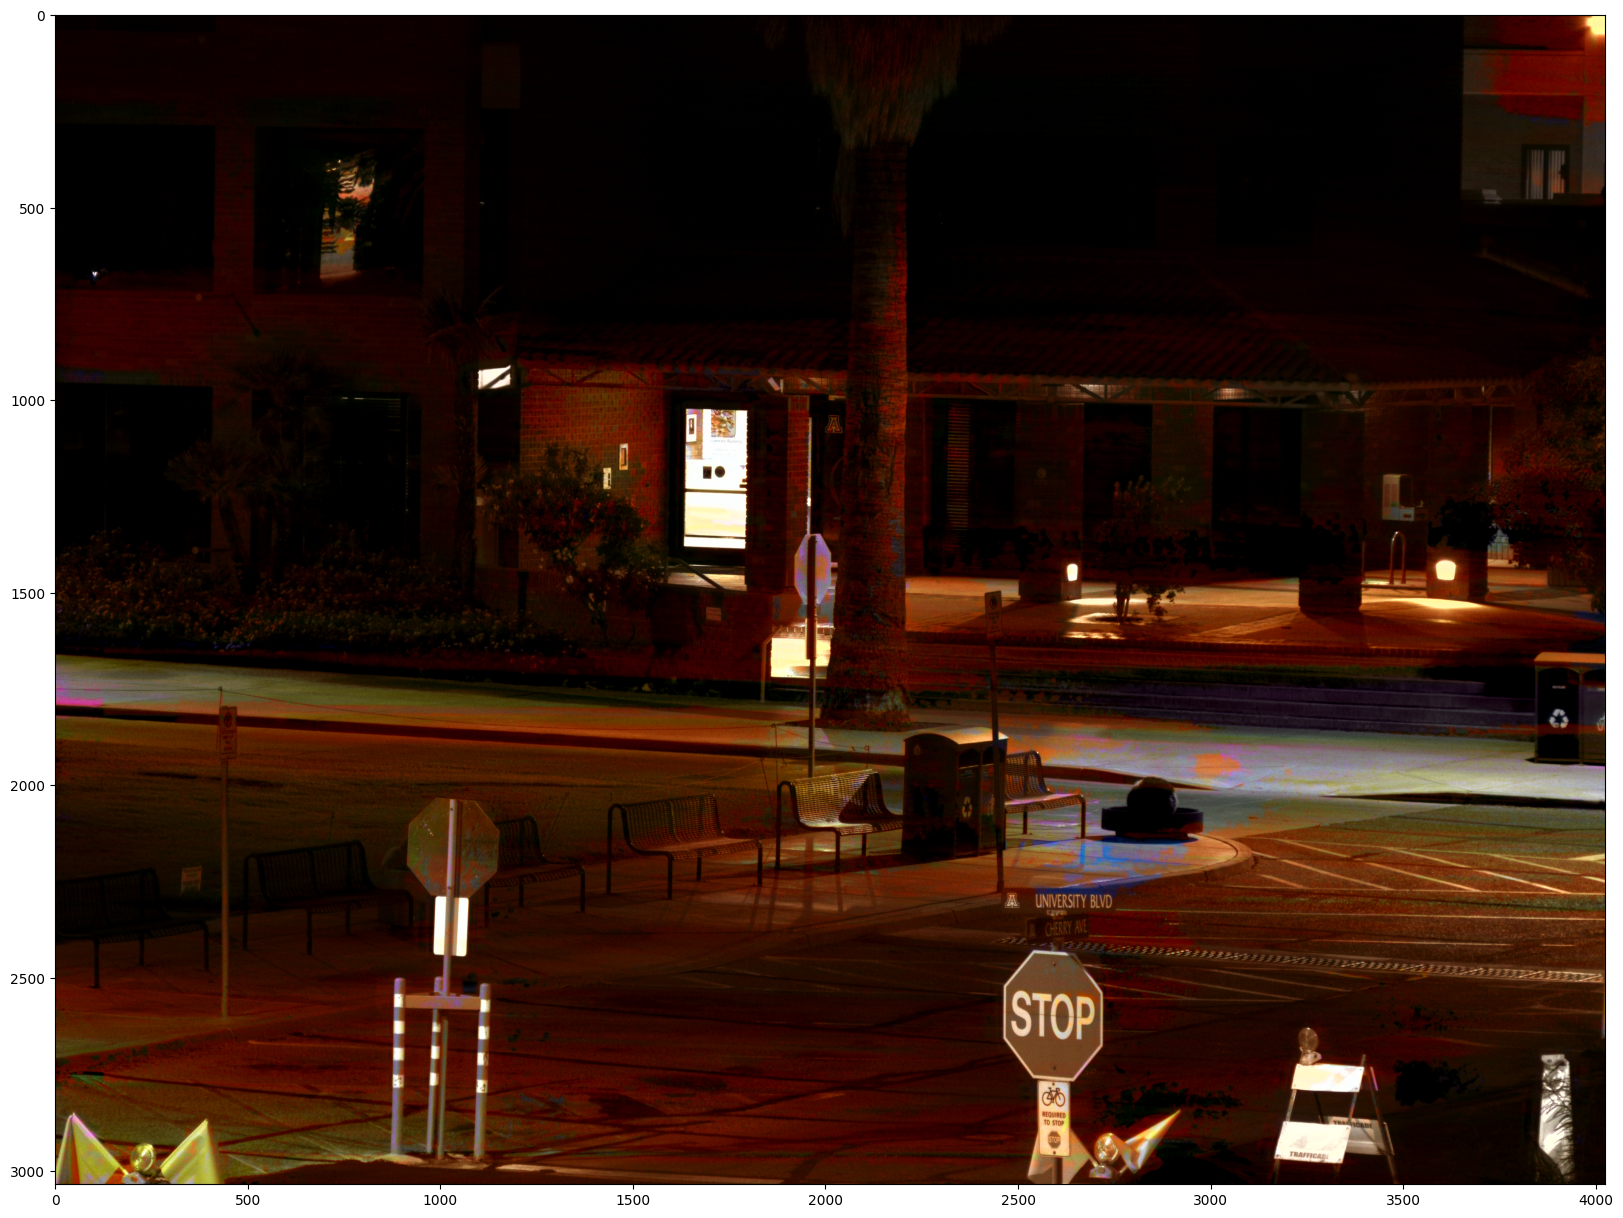

In [18]:
img = torch.clamp(out.float(), 0, 1).squeeze().cpu().numpy().transpose(1, 2, 0)
plt.figure(figsize=(20,16))
plt.imshow(img)
plt.show()

In [ ]:
!pwd


/home/jdylla/Desktop/test


In [19]:
output_path = '/home/jdylla/Desktop/test/saved_image12and50.png'
plt.imsave(output_path, img)

In [ ]:
cv2.imwrite(f'results/lab.png', img[..., ::-1]*255.0)

False